#### Q3. Machine-learning-based Modelling in Python or R  
Instead of using a GARCH-type model for value-at-risk forecasting in Q2, now please use a machine-learning based model to predict the log return of EUR/USD, such as Long Short-Term Memory (LSTM). You can use instead other suitable recurrent neural network, provided that a suitable justification is given. You can choose to include your selected exogenous indicator from Q2 or not in your answer. 


#### Data preparation

This part of the code prepares the EUR/USD log returns and U.S. 10-Year Treasury Yield data by loading, merging, and scaling them for use in a time-series forecasting model. 

The data is split into training and testing sets. 


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and prepare EUR/USD log returns
file_path = "DEXUSEU.csv"
eur_usd_data = pd.read_csv(file_path, parse_dates=['DATE'], index_col='DATE')
eur_usd_data['DEXUSEU'] = pd.to_numeric(eur_usd_data['DEXUSEU'], errors='coerce')
eur_usd_data = eur_usd_data.dropna()
eur_usd_data['Log_Returns'] = np.log(eur_usd_data['DEXUSEU'] / eur_usd_data['DEXUSEU'].shift(1)) * 100  # Scale log returns by 100
eur_usd_log_returns = eur_usd_data[['Log_Returns']].dropna()

# Adds U.S. 10-Year Treasury Yield as an exogenous variable
file_path_2 = "DGS10.csv"
us_yield_data = pd.read_csv(file_path_2, parse_dates=['DATE'], index_col='DATE')
us_yield_data['DGS10'] = pd.to_numeric(us_yield_data['DGS10'], errors='coerce')
us_yield_data.rename(columns={'DGS10': 'US_10Y_Yield'}, inplace=True)
us_yield_data = us_yield_data.dropna()

# Merge EUR/USD log returns with Treasury Yield data
merged_data = pd.concat([eur_usd_log_returns, us_yield_data], axis=1).dropna()

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data)

# Train-test split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


This part of the code creates sequences of past data to prepare the inputs for the LSTM model. Using a sequence length of 60 days, it constructs arrays for `x` (features) and `y` (target variable) where each sequence in `x` is used to predict the next day’s log return in `y`. his structure enables the LSTM to capture temporal dependencies.


In [5]:
# Preparing sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length, :])  # Sequence length of past data
        y.append(data[i+seq_length, 0])  # Predicting only the log return
    return np.array(x), np.array(y)

sequence_length = 60  # Using the past 60 days to predict the next day
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)


This code defines and compiles an LSTM model with two layers of 50 units each, followed by dropout layers to reduce overfitting. 
The output layer has a single neuron to predict the log return. The model is trained with the Adam optimizer to minimize mean squared error (MSE) loss. An early stopping callback monitors validation loss and stops training if no improvement is observed after 5 epochs.


In [7]:
# Defining LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])


Epoch 1/50


C:\Users\kumar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0784 - val_loss: 0.0081
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0204 - val_loss: 0.0086
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0219 - val_loss: 0.0080
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0206 - val_loss: 0.0080
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0208 - val_loss: 0.0088
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0204 - val_loss: 0.0080
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0221 - val_loss: 0.0081
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0079
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0215 - val_loss: 0.0083
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0212 - val_loss: 0.0106
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0088
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0228 - val_l

This part of the code predicts log returns for the test set and calculates the 10% Value-at-Risk (VaR) bounds, using a 5% threshold for each tail. 
It then plots the predicted conditional distribution with vertical lines indicating the calculated left and right VaR bounds.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


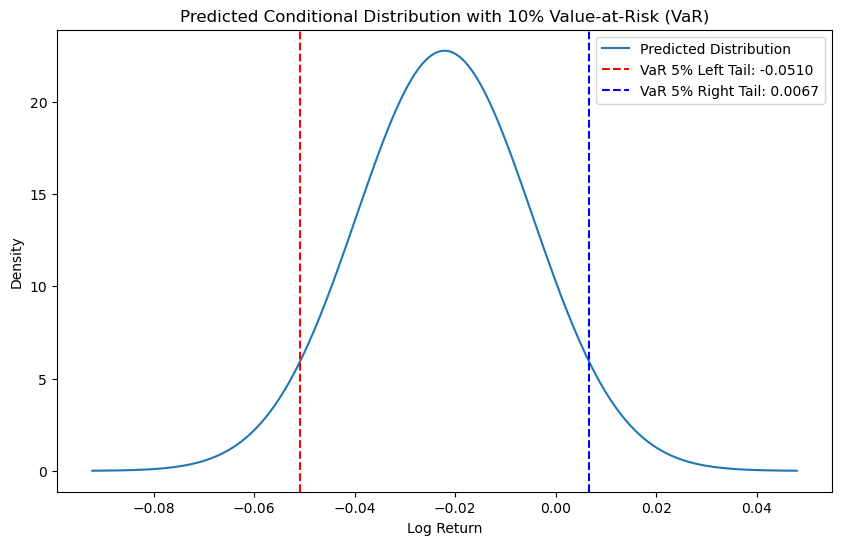

In [9]:
# Predict on the test set
predicted_log_returns = model.predict(x_test)
predicted_log_returns = scaler.inverse_transform(np.concatenate([predicted_log_returns, np.zeros((predicted_log_returns.shape[0], 1))], axis=1))[:, 0]

# Calculate the 10% VaR for a specified date (e.g., end of test set)
predicted_std = np.std(predicted_log_returns)
predicted_mean = np.mean(predicted_log_returns)
var_5_percent_left = predicted_mean - 1.645 * predicted_std
var_5_percent_right = predicted_mean + 1.645 * predicted_std

# Plot conditional distribution and VaR levels
import matplotlib.pyplot as plt

x = np.linspace(predicted_mean - 4 * predicted_std, predicted_mean + 4 * predicted_std, 500)
y = (1 / (predicted_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - predicted_mean) / predicted_std) ** 2)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Predicted Distribution")
plt.axvline(var_5_percent_left, color='red', linestyle='--', label=f'VaR 5% Left Tail: {var_5_percent_left:.4f}')
plt.axvline(var_5_percent_right, color='blue', linestyle='--', label=f'VaR 5% Right Tail: {var_5_percent_right:.4f}')
plt.title('Predicted Conditional Distribution with 10% Value-at-Risk (VaR)')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.show()
